<a href="https://colab.research.google.com/github/akatwinkle/bab_bab/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [ ]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

In [ ]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [4]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

In [31]:
df.head()

,image,is_clothing,style,color,keyword
2,https://glltn.com/wp-content/blogs.dir/1/files...,True,The shoes in the image exhibit a classic sneak...,색상\n 베이지색\n 빨간색 toe 캡,고전적인 스타일\n 높은 탑 디자인\n 캔버스 소재\n 베이지색 빨간색 toe ...
3,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image reflects...,색상 검정색,현대적\n 도시적\n 반항적\n 엣지있는\n 모터사이클\n 스트리트웨어\n 캐주얼...
4,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image leans to...,색상 다크 그레이,스타일 키워드 현대적 미니멀리즘 언더stated 우아함 세련됨 전문성 편안함 루즈핏...
5,https://glltn.com/wp-content/blogs.dir/1/files...,True,The clothing styles in the image reflect a ble...,갈색,실용성과 패션의 융합\n 도시 스트리트웨어 트렌드\n 따뜻함과 편안함 선호\n 갈...
6,https://glltn.com/wp-content/blogs.dir/1/files...,True,The individual in the image is wearing a brown...,색상 갈색,earthiness\n reliability\n comfort\n classic\...


## 14-2 수집 데이터 확인

In [ ]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [ ]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)  # int4: 경량화된 형태
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [ ]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

In [12]:
set_seed(42)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

1


In [11]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.


## 14-5 의류 이미지 여부 판단

In [13]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'is this a picture of clothing MUST say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

No
No
yes
yes
yes
yes
yes
yes
No
yes
yes
yes


## 14-6 의류 판단 결과 시각화

In [ ]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

## 14-7 의류 이미지 필터링

In [ ]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

## 14-8 의류 스타일 분석

In [18]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'anlyze the style of the clothes. Please let me explain the colors and trend changes.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

In [ ]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [ ]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model = 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', gpu_memory_utilization=0.5, max_model_len=10000)

## 14-10 색상 정보 추출

In [23]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해 주세요, 색상 외에 다른 정보는 작성 안합니다.\n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 12-02 07:56:00 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, est. speed input: 447.41 toks/s, output: 24.18 toks/s]


**색상:**
- 베이지색
- 빨간색 toe 캡


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s, est. speed input: 1227.43 toks/s, output: 26.00 toks/s]


색상: 검정색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, est. speed input: 1306.47 toks/s, output: 23.33 toks/s]


색상: 다크 그레이


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s, est. speed input: 1899.05 toks/s, output: 16.95 toks/s]


갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s, est. speed input: 1229.92 toks/s, output: 23.28 toks/s]


**색상:** 갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s, est. speed input: 1854.42 toks/s, output: 16.70 toks/s]


갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, est. speed input: 997.54 toks/s, output: 27.58 toks/s]


- 녹색 (Green)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s, est. speed input: 961.98 toks/s, output: 25.60 toks/s]


색상: 검정색, 흰색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s, est. speed input: 714.90 toks/s, output: 32.15 toks/s]

- **Red**
- **Grey**
- **Beige**


## 14-11 스타일 키워드 추출

In [24]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해주세요, 스타일 키워드 외에 다른 정보는 작성 안합니다.\n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_style 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_style)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it, est. speed input: 190.82 toks/s, output: 37.87 toks/s]


- 고전적인 스타일
- 높은 탑 디자인
- 캔버스 소재
- 베이지색 + 빨간색 toe cap 색상 조합
- 캐주얼 & 스포티한 미학
- 스트리트웨어 인기화
- 빈티지 스타일 부활
- 단순함 & 기능성


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, est. speed input: 118.99 toks/s, output: 39.33 toks/s]


- **현대적**
- **도시적**
- **반항적**
- **엣지있는**
- **모터사이클**
- **스트리트웨어**
- **캐주얼**
- **프리피**
- **다양성**
- **전통적**
- **세련됨**
- **냉각감**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it, est. speed input: 277.75 toks/s, output: 36.31 toks/s]


스타일 키워드: 현대적 미니멀리즘, 언더stated 우아함, 세련됨, 전문성, 편안함, 루즈핏, 간결함, 클래식 요소와 현대적 조화


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it, est. speed input: 142.24 toks/s, output: 38.85 toks/s]


- 실용성과 패션의 융합
- 도시 스트리트웨어 트렌드
- 따뜻함과 편안함 선호
- 갈색 ( Versatility, 신뢰성, 자연스러움 )
- faux fur 디테일
- 기능성과 스타일의 조화
- 최근 트렌드 반영 (편안함과 스타일적 요소)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it, est. speed input: 110.19 toks/s, output: 38.22 toks/s]


- **Earthiness**
- **Reliability**
- **Comfort**
- **Classic**
- **Timeless**
- **Versatile**
- **Casual**
- **Sporty**
- **Functional**
- **Minimalist**
- **Understated Elegance**
- **Clean Lines**
- **Neutral Colors**
- **Eco-friendly**
- **Sustainable**
- **Practical**
- **Retro**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, est. speed input: 291.99 toks/s, output: 36.34 toks/s]


- 캐주얼
- 자연스러운
- 가을/겨울
- 지속가능성
- 친환경
- 실용적
- 다목적


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it, est. speed input: 152.07 toks/s, output: 38.02 toks/s]


- 캐주얼
- 현대적
- 스트리트웨어
- bold lettering
- 그래픽 디자인
- 편안함
- 기능성
- 레이어드 룩
- 텍스처
- 현대 패션의 다양성
- distressed
- 릴렉세이션
- 실용성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it, est. speed input: 225.50 toks/s, output: 36.45 toks/s]


스타일 키워드:
- 미니멀리즘
- 현대적
- 중성색 (블랙, 화이트)
- 단순함
- 세련됨
- 루즈핏
- 편안함
- 다양성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, est. speed input: 213.30 toks/s, output: 36.95 toks/s]

- **스타일**: 현대 캐주얼 패션 트렌드
- **편안함**: Comfort
- **단순함**: Simplicity
- **레이어링**: Layering
- **색상 팔레트**: Neutral Colors (Beige, Grey, Brown)
- **프로포션**: Balanced Silhouette


In [ ]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

## 14-12 텍스트 데이터 정제

In [26]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

## 14-13 워드 클라우드 생성 및 시각화

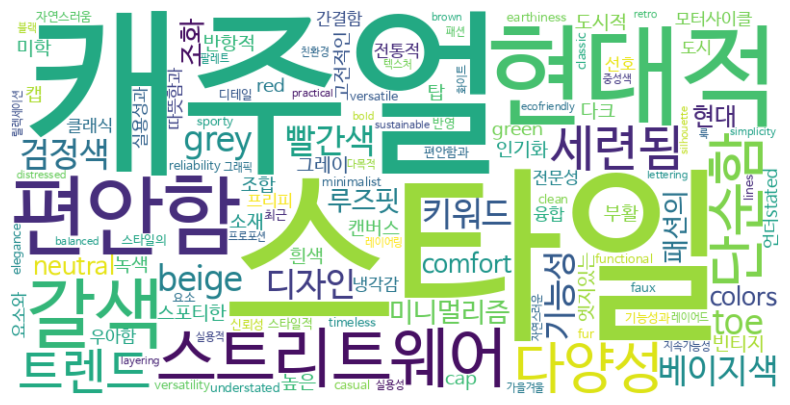

In [27]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [28]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트: {row.style}\n이미지 url: {row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트랜드 방향의 분석 보고서를 작성해주세요. 보고서의 제목은 해외 룩북 스타일 분석입니다. 내용은 전문적이면서 명확하게 작성해주세요. 문서 형식은 markdown으로 만들어주세요."})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:20<00:00, 20.36s/it, est. speed input: 130.24 toks/s, output: 36.54 toks/s]


In [29]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 분석 보고서

## 요약
본 보고서는 최근 여러 패션 룩북에서 관찰되는 주요 트렌드를 종합적으로 분석하고, 이를 통해 현재 패션 산업의 방향성을 제시합니다. 주요 분석 대상은 다양한 색상 팔레트, 소재 선택, 스타일링 기법, 그리고 기능성과 스타일의 균형을 중심으로 이루어졌습니다.

## 트렌드 분석

### 1. **색상 팔레트**
- **자연 친화적 중립색**: 베이지, 그레이, 브라운 등 중립색의 활용이 두드러집니다. 이는 환경 친화적인 패션 트렌드와 맞물려 있으며, 다양한 상황에서 유연하게 활용 가능한 색상입니다.
- **그래픽 및 볼드한 요소**: 스트리트웨어에서는 "ARM"과 같은 그래픽 요소가 포함된 후드티가 인기를 끌고 있습니다. 이는 개인의 개성 표현과 동시에 현대적인 감각을 부여합니다.

### 2. **소재 선택**
- **기능성과 스타일의 조화**: 가죽, 캔버스, 수더린 소재 등이 주요 소재로 사용되며, 특히 기능성과 편안함을 동시에 제공하는 소재들이 주목받고 있습니다. 예를 들어, 오버사이즈 재킷과 수더린 부츠는 실용성과 스타일을 결합한 대표적인 예입니다.
- **지속 가능성**: 친환경 소재와 재활용 소재의 사용이 증가하고 있으며, 이는 소비자들의 환경 의식 증가와 맞물려 있습니다.

### 3. **스타일링 기법**
- **레이어링**: 다양한 레이어링 기법이 활용되고 있습니다. 예를 들어, 카디건과 티셔츠의 조합은 편안함과 세련됨을 동시에 제공하며, 특히 봄과 가을 시즌에 인기가 높습니다.
- **프로포션과 실루엣**: 균형 잡힌 실루엣과 편안한 핏이 중요시되고 있습니다. 오버사이즈 재킷과 짧은 팬츠의 조합은 현대적인 감각을 부여하며, 편안함과 스타일을 동시에 추구합니다.
- **기능성과 패션의 융합**: 아웃도어 활동에 적합한 소재와 디자인이 패션 아이템으로 재해석되고 있습니다. 예를 들어, 수더린 소재의 부츠와 편안한 티셔츠는 일상적인 활동과 캐주얼한 룩을 자연스럽게 연결합니다.

### 4. **주요 트렌드 요약**
- **미니멀리즘과 편안함**: 현대 패션은 간결하고 기능적인 디자인을 선호하며, 이는 다양한 상황에서 유연하게 활용 가능한 아이템을 중심으로 합니다.
- **지속 가능성**: 환경 친화적인 소재와 디자인의 중요성이 강조되고 있습니다.
- **개성 표현**: 그래픽 요소와 볼드한 디자인을 활용한 스트리트웨어는 개인의 개성을 표현하는 수단으로 자리잡고 있습니다.

## 결론
최근 패션 트렌드는 기능성과 스타일의 균형, 지속 가능성, 그리고 개성 표현의 중요성을 강조하고 있습니다. 이러한 요소들은 다양한 연령대와 성별의 소비자들에게 어필하며, 패션 산업이 미래 지향적이고 실용적인 방향으로 진화하고 있음을 보여줍니다. 앞으로도 이러한 경향은 지속될 것으로 예상되며, 소비자들의 다양한 요구와 환경적 의식을 반영할 것입니다.

---

이 보고서는 주어진 이미지와 룩북 분석을 바탕으로 작성되었으며, 패션 트렌드의 주요 특징과 미래 전망을 포괄적으로 다루고 있습니다.